In [4]:
### Import
import yfinance as yf
from datetime import datetime
from pprint import pprint
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv

from timeit import default_timer

from multiprocessing import Pool, Process, Manager

In [5]:
df = pd.read_csv("./data/companylist.csv")

omg = df["Symbol"].tolist()[:1000]
omg2 = omg
for el in omg:
    if el.endswith("W"):
        omg2.remove(el)
      
omg2.remove("ACCP")
omg2.remove("ALIT")
omg2.remove("AHI")
omg2.remove("ACLL")
omg2.remove("AUUD")
omg2.remove("BENE")
omg2.remove("BBRX")
omg2.remove("BCTX")
omg2.remove("BCACU")
omg2.remove("CPTI")
omg2.remove("CNTX")
omg2.remove("CMPX")
#omg2.remove("BLIN")
omg2.remove("BCAC")


In [16]:
coins_list = [
    "ABNB", "V", "AMD", "CSCO", "HNI", "ORI", 
    "SPR", "XOM", "CB", "LOW", "MDLZ", "GRWG", 
    "BIIB", "ADBE", "CRSR", "INTC", "JNJ", 
    "JPM", "LAZ", "NVDA"
]

def fetch(coin):
    #print(f"Starting Tickers {coin}\n")
    return yf.download(coin, period="5y")
    
p = Pool(10)

ohlc = yf.download(coins_list, period="5y")
#print(type(ohlc))
#print(ohlc)
#print(ohlc.keys())

price_matrix = ohlc["Adj Close"]

market_prices = yf.download("SPY", period="max")["Adj Close"]
#price_matrix.tail()
#price_matrix.info()
START_TIME = default_timer()

mcaps = {}
def mkap(d, coin):
    stock = yf.Ticker(coin)
    d[coin] = stock.info["marketCap"]


manager = Manager()
mcaps = manager.dict()

job = [Process(target=mkap, args=(mcaps, i)) for i in coins_list]
[p.start() for p in job]
[p.join() for p in job]
print("=========== MKAP =====================")
print(mcaps)
"""
#mcap = p.map(mkap, coins_list)

elapsed = default_timer() - START_TIME
time_completed_at = "{:5.2f}s".format(elapsed)
print(time_completed_at)

START_TIME = default_timer()
for coin in coins_list:
    stock = yf.Ticker(coin)
    try:
        #print(stock.info["symbol"])
        if not "marketCap" in stock.info:
            print(coin)
        else:
            mcaps[coin] = stock.info["marketCap"]
    except:
        coins_list.remove(coin)
print("=========== MCAP =====================")        
print(mcaps)
elapsed = default_timer() - START_TIME
time_completed_at = "{:5.2f}s".format(elapsed)
print(time_completed_at)
"""
print("FINISHED !")

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed
=========== MKAP =====================
{'V': 482170601472, 'CSCO': 189091561472, 'ORI': 5993081856, 'JNJ': 414309154816, 'HNI': 1471945088, 'GRWG': 2201244672, 'CB': 69475024896, 'XOM': 174287634432, 'SPR': 4129350400, 'CRSR': 3329494528, 'AMD': 110425260032, 'NVDA': 323241803776, 'ABNB': 87705370624, 'ADBE': 239917072384, 'JPM': 387334766592, 'LOW': 117609365504, 'LAZ': 4442853376, 'BIIB': 37679546368, 'INTC': 204162351104, 'MDLZ': 83621453824}
FINISHED !


In [7]:
### Covariance
import pypfopt
from pypfopt import (
    EfficientFrontier, HRPOpt,  objective_functions, 
    CLA, risk_models, expected_returns, plotting
)
    

from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

#Test avec les différent join pour les ticker soù les dimensions de prix ne matchent pas
# min_periods dans la covar pour enlever si il n'y a pas assez de data
#price_matrix = pd.concat([tickers[coin]["price"].rename(coin) for coin in coins_list], axis=1, join='inner')
#price_matrix.cov()
#price_matrix.reset_index(drop=True, inplace=True)
# pour rajouter les date au dataframe de prix
#date_price_matrix = pd.concat([tickers[coin]["date"], price_matrix], axis=1, join='inner')
#df = date_price_matrix
df = price_matrix
tickers = price_matrix
#print(tickers)
#print(price_matrix)

Expected annual return: 21.8%
Annual volatility: 10.5%
Sharpe Ratio: 1.98
Discrete allocation: {'ABNB': 45, 'ADBE': 1, 'BIIB': 2, 'CB': 6, 'CRSR': 93, 'CSCO': 15, 'GRWG': 6, 'INTC': 6, 'JNJ': 15, 'LOW': 3, 'MDLZ': 23, 'ORI': 37, 'V': 3, 'XOM': 20}
Funds remaining: $3.79


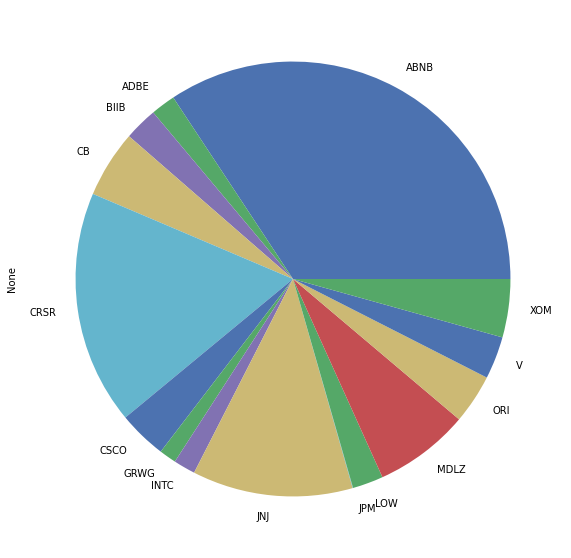

In [8]:
### NORMAL EMA/MEAN HISTORICAL VALUE

#mu = expected_returns.mean_historical_return(df)
#mu = expected_returns.ema_historical_return(df)
mu = expected_returns.capm_return(df)
#mu = expected_returns.returns_from_prices(df)
#mu = expected_returns.prices_from_returns(df)

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
#S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))

gamma = 0.05

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1), gamma=gamma)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001) # 0.1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

ef.min_volatility()
#ef.max_sharpe()
#ef.max_quadratic_utility()
#ef.min_efficient_risk(0.5)
#ef.min_efficient_return(0.5)


cleaned_weights = ef.clean_weights()
#print(cleaned_weights)
ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # 1% US Bond rate

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10), normalize=True, labels=cleaned_weights.keys())

capital = 19500
latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)#, short_ratio=0.3)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

#pd.Series(cleaned_weights).plot.pie(figsize=(10,10))

ef: <pypfopt.hierarchical_portfolio.HRPOpt object at 0x7f8a1ecbf970>
cleaned weight: OrderedDict([('ABNB', 0.03063), ('ADBE', 0.0), ('AMD', 0.00291), ('BIIB', 0.00312), ('CB', 0.00944), ('CRSR', 0.0275), ('CSCO', 0.02547), ('GRWG', 0.06048), ('HNI', 0.12727), ('INTC', 0.0155), ('JNJ', 0.0041), ('JPM', 0.0041), ('LAZ', 0.07278), ('LOW', 0.00137), ('MDLZ', 0.02287), ('NVDA', 0.0), ('ORI', 0.56177), ('SPR', 0.00654), ('V', 0.00031), ('XOM', 0.02372)])
Expected annual return: 759504.5%
Annual volatility: 4351.7%
Sharpe Ratio: 174.53
Discrete allocation: {'ABNB': 4, 'AMD': 1, 'CB': 1, 'CRSR': 15, 'CSCO': 11, 'GRWG': 29, 'HNI': 72, 'INTC': 6, 'JNJ': 1, 'JPM': 1, 'LAZ': 33, 'MDLZ': 8, 'ORI': 556, 'SPR': 3, 'XOM': 11}
Funds remaining: $7.64


<AxesSubplot:ylabel='None'>

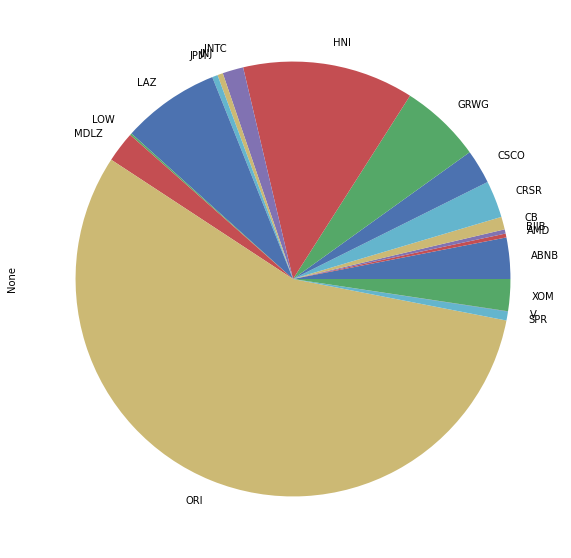

In [9]:
### HRPOPT TECHNIQUE

# En HRP on ne fait pas d'estimation des perfs 
mu = df

#S = risk_models.sample_cov(df)
#S = risk_models.semicovariance(df)
#S = risk_models.exp_cov(df)
#S = risk_models.min_cov_determinant(df)
#S = risk_models.CovarianceShrinkage(df.cov(min_periods=15))
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf')
#S = risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor')
S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

capital = 19500
risk_free_rate = 0.01

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

ef = HRPOpt(mu, S)

#import scipy.cluster.hierarchy as sch
#print(sch._LINKAGE_METHODS)
raw_weights = ef.optimize('single')


print(f"ef: {ef}")
#print(f"raw_weights: {raw_weights}")
cleaned_weights = ef.clean_weights()
print(f"cleaned weight: {cleaned_weights}")

ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)

allocation, leftover = da.lp_portfolio()
#allocation, leftover = da.greedy_portfolio()

print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

pd.Series([abs(i) for i in cleaned_weights.values()]).plot.pie(figsize=(10,10), normalize=True, labels=cleaned_weights.keys())

In [10]:
### HRPOPT TECHNIQUE

# En HRP on ne fait pas d'estimation des perfs 
mu = df

S = risk_models.risk_matrix(prices=df, method='oracle_approximating')

capital = 19500
risk_free_rate = 0.01

#mu.plot.barh(figsize=(10,5))
#plotting.plot_covariance(S, plot_correlation=True)

ef = HRPOpt(mu, S)

#import scipy.cluster.hierarchy as sch
#print(sch._LINKAGE_METHODS)
result = {}
for method in ("single", "complete", "average", "weighted", "centroid", "median", "ward"):
    raw_weights = ef.optimize(method)
    #raw_weights = ef.optimize('complete')

    #print(f"ef: {ef}")
    #print(f"raw_weights: {raw_weights}")
    cleaned_weights = ef.clean_weights()
    #print(f"cleaned weight: {cleaned_weights}")

    portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)

    latest_prices = get_latest_prices(df)
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)

    allocation, leftover = da.lp_portfolio()
    #allocation, leftover = da.greedy_portfolio()

    #print("Discrete allocation:", allocation)
    #print("Funds remaining: ${:.2f}".format(leftover))
    result[method] = {
        "return": portfolio_performance[0],
        "risk": portfolio_performance[1],
        "sharpe ratio": portfolio_performance[2],
        "allocation": allocation,
        "leftover": leftover
    }
#pprint(result)
print("FINISHED !")

FINISHED !


======================== Expected performance =================
annual return: 896125.470%
annual volatility: 4935.997%
sharpe ratio: 1.82e+02
Discrete allocation: {'ABNB': 4, 'AMD': 2, 'CB': 2, 'CRSR': 18, 'CSCO': 7, 'GRWG': 36, 'HNI': 108, 'INTC': 5, 'JNJ': 1, 'JPM': 2, 'LAZ': 56, 'LOW': 1, 'MDLZ': 22, 'ORI': 365, 'SPR': 3, 'XOM': 12}
Funds remaining: $4.40


<AxesSubplot:ylabel='None'>

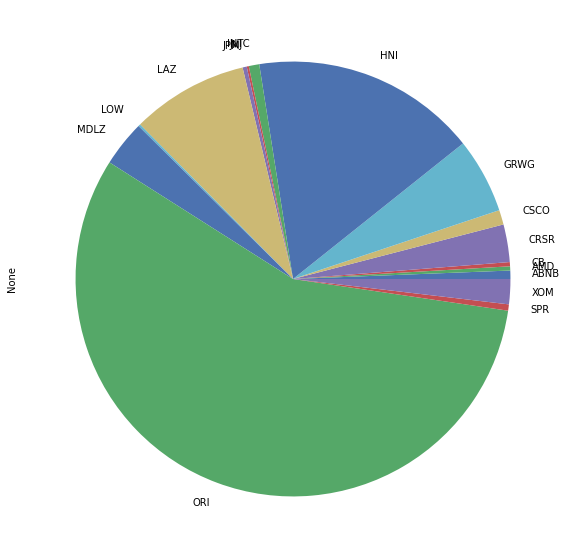

In [11]:
#pprint(result)
  
b = {k: v['return'] for k, v in sorted(result.items(), key=lambda item: item[1]["return"])}
#print("======== B ========")
#print(b.items())

max_values = max(list(b.values()))
#print(max_values)

opt_portfolio = [(k, v) for k, v in b.items() if v == max_values] # getting all keys containing the `maximum`
last = result[opt_portfolio[0][0]]
#print(last)

print("======================== Expected performance =================")
print(f"annual return: {last['return']:.3%}")
print(f"annual volatility: {last['risk']:.3%}")
print(f"sharpe ratio: {last['sharpe ratio']:.3}")
print(f"Discrete allocation: {last['allocation']}")
print(f"Funds remaining: ${last['leftover']:.2f}")

pd.Series([abs(i) for i in last['allocation'].values()]).plot.pie(figsize=(10,10), normalize=True, labels=last['allocation'].keys())


In [12]:
### NORMAL EMA/MEAN HISTORICAL VALUE
risk_free_rate = 0.01
broker_fees = 0.001
capital = 19500
initial_weights = np.array([1/len(tickers.columns)] * len(tickers.columns))

return_list = {
    'mean': expected_returns.mean_historical_return(df),
    'ema': expected_returns.ema_historical_return(df),
    'capm': expected_returns.capm_return(df),
}

risk_list = {
    'sample_cov': risk_models.sample_cov(df),
    'semi_cov': risk_models.semicovariance(df),
    'exp_cov': risk_models.exp_cov(df),
    'min_cov_det': risk_models.min_cov_determinant(df),
    #'cov_shrink': risk_models.CovarianceShrinkage(df.cov(min_periods=100)),
    'ledoit_wolf': risk_models.risk_matrix(prices=df, method='ledoit_wolf'),
    'ld_wolf_single': risk_models.risk_matrix(prices=df, method='ledoit_wolf_single_factor'),
    'oracle_approx': risk_models.risk_matrix(prices=df, method='oracle_approximating'),
}

result = {}

for return_name, ret in return_list.items():
    for risk_name, risk in risk_list.items():
        print((return_name, risk_name))
        #for i in np.arange(0, 1, 0.01):
        for i in np.arange(0, 1, 0.1):
            gamma = i

            ef = EfficientFrontier(ret, risk, weight_bounds=(0, 1), gamma=gamma)
            ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) 
            ef.add_objective(objective_functions.L2_reg, gamma=gamma)  

            ef.min_volatility()
            #ef.max_sharpe()
            #ef.max_quadratic_utility()
            #ef.min_efficient_risk(0.5)
            #ef.min_efficient_return(0.5)

            cleaned_weights = ef.clean_weights()
            portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate) 


            latest_prices = get_latest_prices(df)
            da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=capital)
            allocation, leftover = da.lp_portfolio()
            result[(return_name, risk_name, i)] = {
                "return": portfolio_performance[0],
                "risk": portfolio_performance[1],
                "sharpe ratio": portfolio_performance[2],
                "allocation": allocation,
                "leftover": leftover,
                "cleaned_weights": cleaned_weights,
            }
            #allocation, leftover = da.greedy_portfolio()

            #print("Discrete allocation:", allocation)
            #print("Funds remaining: ${:.2f}".format(leftover))
#pprint(result)
print("FINISHED !")

/home/rems/.local/share/virtualenvs/data-acc-ZSLQhKri/lib/python3.8/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


('mean', 'sample_cov')
('mean', 'semi_cov')
('mean', 'exp_cov')
('mean', 'min_cov_det')
('mean', 'ledoit_wolf')
('mean', 'ld_wolf_single')
('mean', 'oracle_approx')
('ema', 'sample_cov')
('ema', 'semi_cov')
('ema', 'exp_cov')
('ema', 'min_cov_det')
('ema', 'ledoit_wolf')
('ema', 'ld_wolf_single')
('ema', 'oracle_approx')
('capm', 'sample_cov')
('capm', 'semi_cov')
('capm', 'exp_cov')
('capm', 'min_cov_det')
('capm', 'ledoit_wolf')
('capm', 'ld_wolf_single')
('capm', 'oracle_approx')
FINISHED !


======== B ========
16.228005597743973
======================== Expected performance =================
annual return: 1622.801%
annual volatility: 1.303%
sharpe ratio: 1.24e+03
Discrete allocation: {'ABNB': 55, 'CB': 1, 'CRSR': 223, 'CSCO': 2, 'GRWG': 4, 'JNJ': 6, 'LOW': 1, 'MDLZ': 6, 'ORI': 25, 'SPR': 3, 'V': 2, 'XOM': 10}
Funds remaining: $29.35


<AxesSubplot:ylabel='None'>

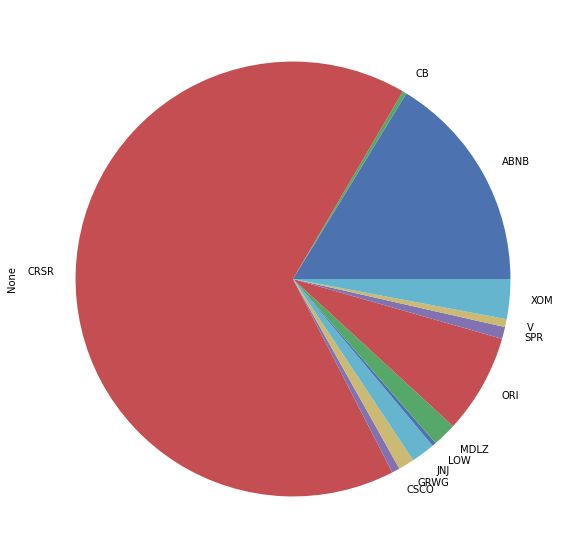

In [13]:
#pprint(result)
  
b = {k: v['return'] for k, v in sorted(result.items(), key=lambda item: item[1]["return"])}
print("======== B ========")
#print(b.items())
max_values = max(list(b.values()))
print(max_values)

opt_portfolio = [(k, v) for k, v in b.items() if v == max_values] # getting all keys containing the `maximum`
last = result[opt_portfolio[0][0]]
#print(last)

print("======================== Expected performance =================")
print(f"annual return: {last['return']:.3%}")
print(f"annual volatility: {last['risk']:.3%}")
print(f"sharpe ratio: {last['sharpe ratio']:.3}")
print(f"Discrete allocation: {last['allocation']}")
print(f"Funds remaining: ${last['leftover']:.2f}")

pd.Series([abs(i) for i in last['allocation'].values()]).plot.pie(figsize=(10,10), normalize=True, labels=last['allocation'].keys())

=== PRICES (df) ====
                  ABNB        ADBE        AMD        BIIB          CB  \
Date                                                                    
2016-01-04         NaN   91.970001   2.770000  294.619995  101.970673   
2016-01-05         NaN   92.339996   2.750000  296.700012  103.001740   
2016-01-06         NaN   91.019997   2.510000  293.679993  101.083038   
2016-01-07         NaN   89.110001   2.280000  284.010010  100.042961   
2016-01-08         NaN   87.849998   2.140000  280.589996   98.590469   
...                ...         ...        ...         ...         ...   
2020-12-24  154.839996  499.859985  91.809998  248.889999  150.830002   
2020-12-28  149.000000  498.950012  91.599998  244.149994  151.880005   
2020-12-29  150.000000  502.109985  90.620003  243.460007  150.899994   
2020-12-30  148.429993  497.450012  92.290001  243.580002  151.929993   
2020-12-31  146.800003  500.119995  91.709999  244.860001  153.919998   

                 CRSR       C

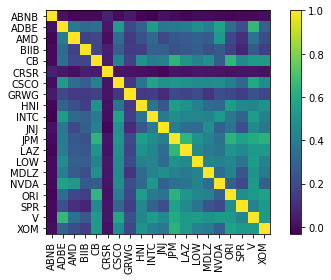

=== MARKET PRIOR ====
ABNB    0.020618
ADBE    0.157133
AMD     0.219319
BIIB    0.115205
CB      0.111714
CRSR    0.024190
CSCO    0.137539
GRWG    0.112496
HNI     0.146626
INTC    0.157701
JNJ     0.091972
JPM     0.149212
LAZ     0.151866
LOW     0.138085
MDLZ    0.102141
NVDA    0.219972
ORI     0.118503
SPR     0.158356
V       0.147527
XOM     0.123524
dtype: float64
==== VIEWDICT =====
{'ABNB': 0.1, 'V': 0.1, 'AMD': 0.1, 'CSCO': 0.1, 'HNI': 0.1}
==== INTERVALS =====
[(0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1)]
==== VARIANCES =====
[0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005]
==== OMEGA =====
[[0.0025 0.     0.     0.     0.    ]
 [0.     0.0025 0.     0.     0.    ]
 [0.     0.     0.0025 0.     0.    ]
 [0.     0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.     0.0025]]
==== RET_BLACKLITTERMAN =====
ABNB    0.027212
ADBE    0.117491
AMD     0.109853
BIIB    0.086912
CB      0.084149
CRSR    0.

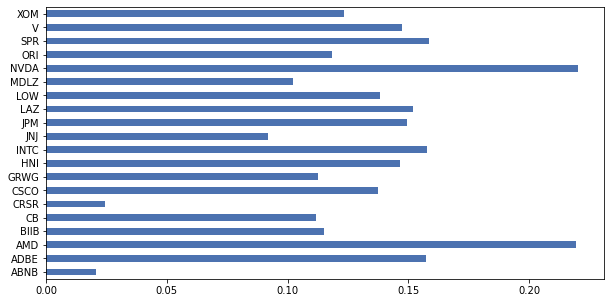

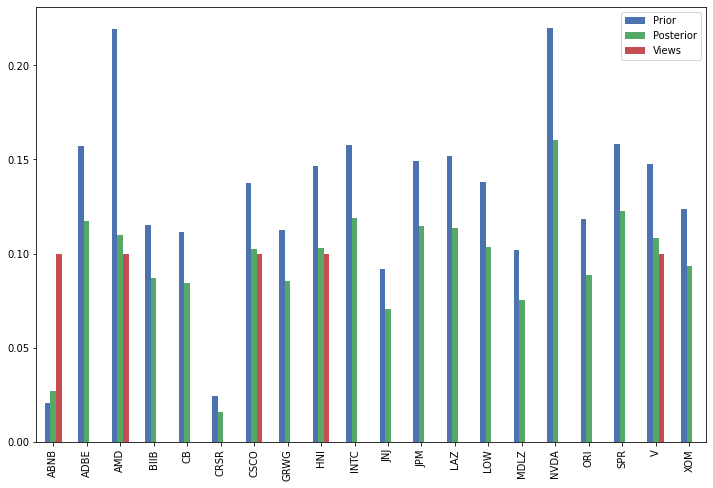

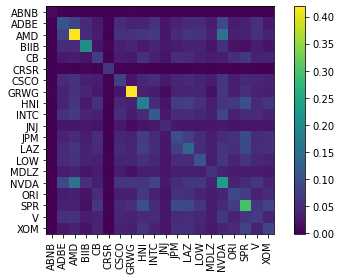

Expected annual return: 8.7%
Annual volatility: 18.3%
Sharpe Ratio: 0.42
======================== Expected performance =================
annual return: 8.727%
annual volatility: 18.330%
sharpe ratio: 0.422
{'ABNB': 12, 'ADBE': 2, 'AMD': 6, 'BIIB': 4, 'CB': 7, 'CRSR': 43, 'CSCO': 22, 'GRWG': 20, 'HNI': 22, 'INTC': 18, 'JNJ': 8, 'JPM': 7, 'LAZ': 19, 'LOW': 6, 'MDLZ': 20, 'NVDA': 1, 'ORI': 50, 'SPR': 16, 'V': 4, 'XOM': 25}
Leftover: $6.53


/home/rems/.local/share/virtualenvs/data-acc-ZSLQhKri/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1600: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  results = ax.pie(y, labels=blabels, **kwds)


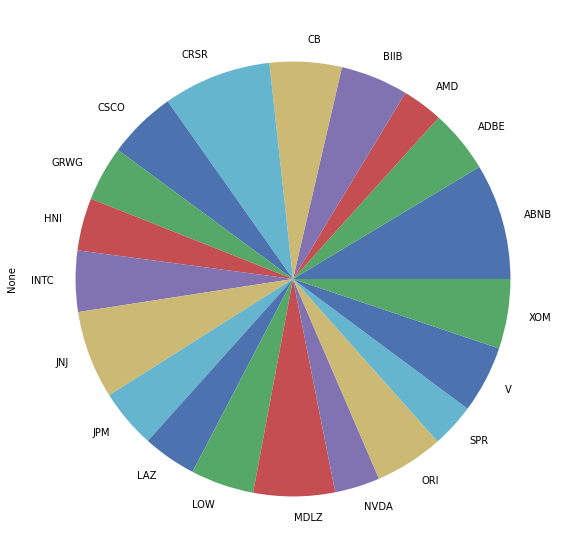

In [17]:
# Black-Litterman

from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

print("=== PRICES (df) ====")
print(df)

print("=== MCAPS ====")
print(mcaps)

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()
print("=== RISK MODEL ====")
print(S)
delta = black_litterman.market_implied_risk_aversion(market_prices) # Je trouve le Delta elevé
print("=== DELTA ====")
print(delta)
#delta = 2.5042720332949346

plotting.plot_covariance(S, plot_correlation=True);

"""
ANCIEN CALCUL FAIT CELLULE 1
print(tickers["bitcoin"]["market_cap"].iloc[-1])
#mcaps = {i:tickers[i].iloc[-1] for i in coins_list}

print("==== MCAPS =====")
print(mcaps)
### MCAPS == PRICE != MARKET_CAP
"""

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print("=== MARKET PRIOR ====")
print(market_prior)

market_prior.plot.barh(figsize=(10,5));
risk_free_rate = 0.01

# Contruction de la view pour estimer

# Relative View
"""Each view has a corresponding row in the picking matrix (the order matters)
Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe.
Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns. 
The numbers in each row should sum up to 0."""

"""
Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1) # Absolute
P = np.array( # Relative
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)
# Absolute View
viewdict = {
    "bitcoin": 0.10,
    "ethereum": 0.30,
    "binancecoin": 0.05,
    "chainlink": 0.05,
    "eos": 0.20,
}

# Optionnal - Arbitrary confidences
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]
"""
#bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek", tau=0.05)
# Optional - Standard deviation confidences
# Absolute View
"""
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
    "ORI": 0.10, 
    "SPR": 0.10, 
    "XOM": 0.10, 
    "CB": 0.10, 
    "LOW": 0.10, 
    "MDLZ": 0.10, 
    "GRWG": 0.10, 
    "BIIB": 0.10, 
    "NVDA": 0.10, 
    "ADBE": 0.10, 
    "CRSR": 0.10, 
    "INTC": 0.10, 
    "JNJ": 0.10, 
    "JPM": 0.10, 
    "LAZ": 0.10, 
}
"""
viewdict = {}
intervals = []
double_list = (
    [{"ABNB": 0.10}, (0, 0.1)],
    [{"V": 0.10}, (0, 0.1)],
    [{"AMD": 0.10}, (0, 0.1)],
    [{"CSCO": 0.10}, (0, 0.1)],
    [{"HNI": 0.10}, (0, 0.1)],
)
for el in double_list:
    viewdict.update(el[0])
    intervals.append(el[1])
"""    
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
}
"""
"""
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
]
"""
"""
intervals = [
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
]
"""

print("==== VIEWDICT =====")
print(viewdict)
print("==== INTERVALS =====")
print(intervals)


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)
    
print("==== VARIANCES =====")
print(variances)
omega = np.diag(variances)

print("==== OMEGA =====")
print(omega)

# We are using the shortcut to automatically compute market-implied prior
# pi = market_prior
bl = BlackLittermanModel(
    cov_matrix=S, 
    pi="market", 
    absolute_views=viewdict,
    market_caps=mcaps, 
    risk_aversion=delta, 
    omega=omega, 
    tau=0.05, 
    risk_free_rate=risk_free_rate
)
# args de BlackLittermanModel (cov_matrix, pi=None, absolute_views=None, Q=None, P=None, omega=None, view_confidences=None, tau=0.05, risk_aversion=1)
"""
#fig, ax = plt.subplots(figsize=(7,7))
#im = ax.imshow(bl.omega)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(bl.tickers)))
#ax.set_yticks(np.arange(len(bl.tickers)))

#ax.set_xticklabels(bl.tickers)
#ax.set_yticklabels(bl.tickers)
#plt.show()
#np.diag(bl.omega)
"""

# Posterior estimate of returns
ret_bl = bl.bl_returns()
print("==== RET_BLACKLITTERMAN =====")
print(ret_bl)
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T


rets_df.plot.bar(figsize=(12,8));

# Posterior covariance estimate
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);


### PORTFOLIO ALLOCATION

from pypfopt import EfficientFrontier, objective_functions
gamma = 1
broker_fees = 0.001


initial_weights = np.array([
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
])

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

#ef.max_sharpe() # Pk conflict avec les fonctions de régularisations ?
ef.min_volatility()
#bl.bl_weights(delta)
weights = ef.clean_weights()


pd.Series(weights).plot.pie(figsize=(10,10));


from pypfopt import DiscreteAllocation

capital = 19500
portfolio_performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
expected_annual_return = portfolio_performance[0]
expected_annual_volatility = portfolio_performance[1]
expected_sharpe_ratio = portfolio_performance[2]
print("======================== Expected performance =================")
print(f"annual return: {expected_annual_return:.3%}")
print(f"annual volatility: {expected_annual_volatility:.3%}")
print(f"sharpe ratio: {expected_sharpe_ratio:.3}")

da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=capital)
alloc, leftover = da.lp_portfolio()

print(alloc)
print(f"Leftover: ${leftover:.2f}")

=== PRICES (df) ====
                  ABNB        ADBE        AMD        BIIB          CB  \
Date                                                                    
2016-01-04         NaN   91.970001   2.770000  294.619995  101.970673   
2016-01-05         NaN   92.339996   2.750000  296.700012  103.001740   
2016-01-06         NaN   91.019997   2.510000  293.679993  101.083038   
2016-01-07         NaN   89.110001   2.280000  284.010010  100.042961   
2016-01-08         NaN   87.849998   2.140000  280.589996   98.590469   
...                ...         ...        ...         ...         ...   
2020-12-24  154.839996  499.859985  91.809998  248.889999  150.830002   
2020-12-28  149.000000  498.950012  91.599998  244.149994  151.880005   
2020-12-29  150.000000  502.109985  90.620003  243.460007  150.899994   
2020-12-30  148.429993  497.450012  92.290001  243.580002  151.929993   
2020-12-31  146.800003  500.119995  91.709999  244.860001  153.919998   

                 CRSR       C

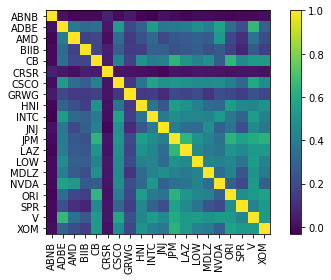

=== MARKET PRIOR ====
ABNB    0.020618
ADBE    0.157133
AMD     0.219319
BIIB    0.115205
CB      0.111714
CRSR    0.024190
CSCO    0.137539
GRWG    0.112496
HNI     0.146626
INTC    0.157701
JNJ     0.091972
JPM     0.149212
LAZ     0.151866
LOW     0.138085
MDLZ    0.102141
NVDA    0.219972
ORI     0.118503
SPR     0.158356
V       0.147527
XOM     0.123524
dtype: float64
==== VIEWDICT =====
{'ABNB': 0.1, 'V': 0.1, 'AMD': 0.1, 'CSCO': 0.1, 'HNI': 0.1}
==== INTERVALS =====
[(0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1), (0, 0.1)]
==== VARIANCES =====
[0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005]
==== OMEGA =====
[[0.0025 0.     0.     0.     0.    ]
 [0.     0.0025 0.     0.     0.    ]
 [0.     0.     0.0025 0.     0.    ]
 [0.     0.     0.     0.0025 0.    ]
 [0.     0.     0.     0.     0.0025]]
==== RET_BLACKLITTERMAN =====
ABNB    0.027212
ADBE    0.117491
AMD     0.109853
BIIB    0.086912
CB      0.084149
CRSR    0.

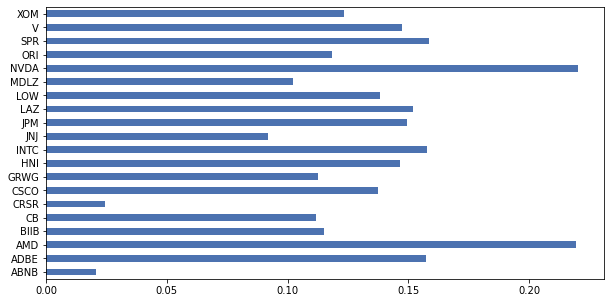

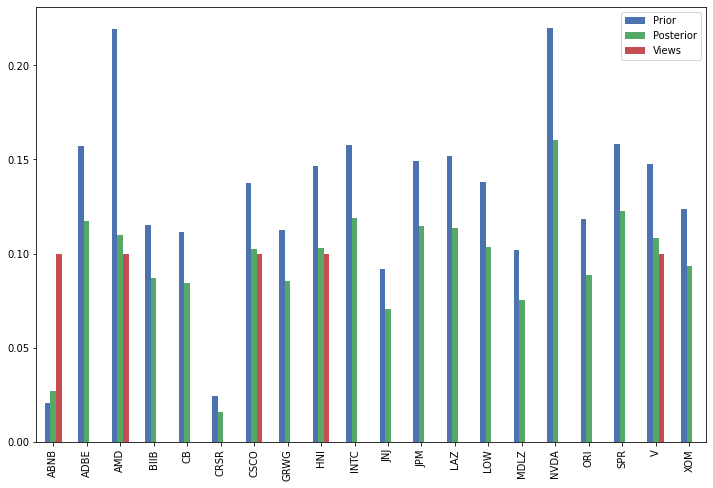

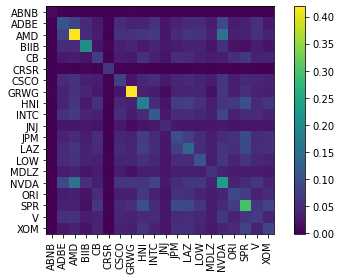

======== B ========
[0.29]
Expected annual return: 7.6%
Annual volatility: 15.4%
Sharpe Ratio: 0.43
======================== Expected performance =================
annual return: 7.574%
annual volatility: 15.409%
sharpe ratio: 0.427
{'ABNB': 20, 'ADBE': 2, 'AMD': 2, 'BIIB': 4, 'CB': 7, 'CRSR': 66, 'CSCO': 22, 'GRWG': 15, 'HNI': 13, 'INTC': 14, 'JNJ': 11, 'JPM': 5, 'LAZ': 11, 'LOW': 5, 'MDLZ': 25, 'ORI': 50, 'SPR': 5, 'V': 4, 'XOM': 25}
Leftover: $17.18


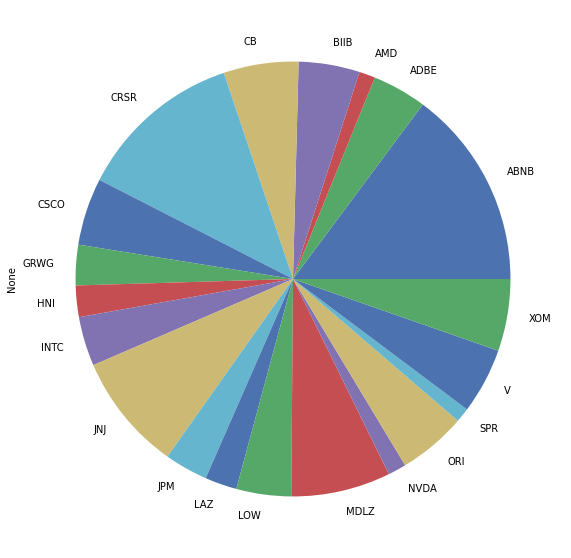

In [18]:
# Black-Litterman

from pypfopt import black_litterman, risk_models

"""
cov_matrix is a NxN sample covariance matrix
mcaps is a dict of market caps
market_prices is a series of S&P500 prices
"""

from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

print("=== PRICES (df) ====")
print(df)

print("=== MCAPS ====")
print(mcaps)

S = risk_models.CovarianceShrinkage(df).ledoit_wolf()
print("=== RISK MODEL ====")
print(S)
delta = black_litterman.market_implied_risk_aversion(market_prices) # Je trouve le Delta elevé
print("=== DELTA ====")
print(delta)
#delta = 2.5042720332949346

plotting.plot_covariance(S, plot_correlation=True);

"""
ANCIEN CALCUL FAIT CELLULE 1
print(tickers["bitcoin"]["market_cap"].iloc[-1])
#mcaps = {i:tickers[i].iloc[-1] for i in coins_list}

print("==== MCAPS =====")
print(mcaps)
### MCAPS == PRICE != MARKET_CAP
"""

market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
print("=== MARKET PRIOR ====")
print(market_prior)

market_prior.plot.barh(figsize=(10,5));
risk_free_rate = 0.01
broker_fees = 0.001
initial_weights = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
])
# Contruction de la view pour estimer

# Relative View
"""Each view has a corresponding row in the picking matrix (the order matters)
Absolute views have a single 1 in the column corresponding to the ticker’s order in the universe.
Relative views have a positive number in the nominally outperforming asset columns and a negative number in the nominally underperforming asset columns. 
The numbers in each row should sum up to 0."""

"""
Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1) # Absolute
P = np.array( # Relative
    [
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
    ]
)
# Absolute View
viewdict = {
    "bitcoin": 0.10,
    "ethereum": 0.30,
    "binancecoin": 0.05,
    "chainlink": 0.05,
    "eos": 0.20,
}

# Optionnal - Arbitrary confidences
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7
]
"""
#bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, view_confidences=confidences, omega="idzorek", tau=0.05)
# Optional - Standard deviation confidences
# Absolute View
"""
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
    "ORI": 0.10, 
    "SPR": 0.10, 
    "XOM": 0.10, 
    "CB": 0.10, 
    "LOW": 0.10, 
    "MDLZ": 0.10, 
    "GRWG": 0.10, 
    "BIIB": 0.10, 
    "NVDA": 0.10, 
    "ADBE": 0.10, 
    "CRSR": 0.10, 
    "INTC": 0.10, 
    "JNJ": 0.10, 
    "JPM": 0.10, 
    "LAZ": 0.10, 
}
"""
viewdict = {}
intervals = []
double_list = (
    [{"ABNB": 0.10}, (0, 0.1)],
    [{"V": 0.10}, (0, 0.1)],
    [{"AMD": 0.10}, (0, 0.1)],
    [{"CSCO": 0.10}, (0, 0.1)],
    [{"HNI": 0.10}, (0, 0.1)],
)
for el in double_list:
    viewdict.update(el[0])
    intervals.append(el[1])
"""    
viewdict = {
    "ABNB": 0.10, 
    "V": 0.10, 
    "AMD": 0.10, 
    "CSCO": 0.10,
    "HNI": 0.10, 
}
"""
"""
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
]
"""
"""
intervals = [
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
    (0, 0.1),
]
"""

print("==== VIEWDICT =====")
print(viewdict)
print("==== INTERVALS =====")
print(intervals)


variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)
    
print("==== VARIANCES =====")
print(variances)
omega = np.diag(variances)

print("==== OMEGA =====")
print(omega)

# We are using the shortcut to automatically compute market-implied prior
# pi = market_prior
bl = BlackLittermanModel(
    cov_matrix=S, 
    pi="market", 
    absolute_views=viewdict,
    market_caps=mcaps, 
    risk_aversion=delta, 
    omega=omega, 
    tau=0.05, 
    risk_free_rate=risk_free_rate
)
# args de BlackLittermanModel (cov_matrix, pi=None, absolute_views=None, Q=None, P=None, omega=None, view_confidences=None, tau=0.05, risk_aversion=1)
"""
#fig, ax = plt.subplots(figsize=(7,7))
#im = ax.imshow(bl.omega)

# We want to show all ticks...
#ax.set_xticks(np.arange(len(bl.tickers)))
#ax.set_yticks(np.arange(len(bl.tickers)))

#ax.set_xticklabels(bl.tickers)
#ax.set_yticklabels(bl.tickers)
#plt.show()
#np.diag(bl.omega)
"""

# Posterior estimate of returns
ret_bl = bl.bl_returns()
print("==== RET_BLACKLITTERMAN =====")
print(ret_bl)
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T


rets_df.plot.bar(figsize=(12,8));

# Posterior covariance estimate
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);


### PORTFOLIO ALLOCATION
test = {}

from pypfopt import EfficientFrontier, objective_functions
for i in np.arange(0, 1, 0.01):
    gamma = i



    initial_weights = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
    ])

    ef = EfficientFrontier(ret_bl, S_bl)
    ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
    ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

    #ef.max_sharpe() # Pk conflict avec les fonctions de régularisations ?
    ef.min_volatility()
    #bl.bl_weights(delta)
    weights = ef.clean_weights()


    from pypfopt import DiscreteAllocation

    capital = 19500
    portfolio_performance = ef.portfolio_performance(verbose=False, risk_free_rate=risk_free_rate)
    expected_annual_return = portfolio_performance[0]
    expected_annual_volatility = portfolio_performance[1]
    expected_sharpe_ratio = portfolio_performance[2]
    """print("======================== Expected performance =================")
    print(f"annual return: {expected_annual_return:.3%}")
    print(f"annual volatility: {expected_annual_volatility:.3%}")
    print(f"sharpe ratio: {expected_sharpe_ratio:.3}")"""

    da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=capital)
    alloc, leftover = da.lp_portfolio()

    #print(alloc)
    #print(f"Leftover: ${leftover:.2f}")
    test[gamma] = portfolio_performance[2]
#print(test)   
b = {k: v for k, v in sorted(test.items(), key=lambda item: item[1])}
print("======== B ========")
#print(b)
max_value = max(test.values())
max_keys = [k for k, v in test.items() if v == max_value] # getting all keys containing the `maximum`
print(max_keys)


gamma = max_keys[0]


initial_weights = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.11, 9.11, 7.73, 7.85, 5.80, 4.89
])

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=broker_fees) # 0.1% broker commission
ef.add_objective(objective_functions.L2_reg, gamma=gamma)  # default is gamma=1

#ef.max_sharpe() # Pk conflict avec les fonctions de régularisations ?
ef.min_volatility()
#bl.bl_weights(delta)
weights = ef.clean_weights()

pd.Series(weights).plot.pie(figsize=(10,10), normalize=True);

from pypfopt import DiscreteAllocation

capital = 19500
portfolio_performance = ef.portfolio_performance(verbose=True, risk_free_rate=risk_free_rate)
expected_annual_return = portfolio_performance[0]
expected_annual_volatility = portfolio_performance[1]
expected_sharpe_ratio = portfolio_performance[2]
print("======================== Expected performance =================")
print(f"annual return: {expected_annual_return:.3%}")
print(f"annual volatility: {expected_annual_volatility:.3%}")
print(f"sharpe ratio: {expected_sharpe_ratio:.3}")

da = DiscreteAllocation(weights, df.iloc[-1], total_portfolio_value=capital)
alloc, leftover = da.lp_portfolio()

print(alloc)
print(f"Leftover: ${leftover:.2f}")